In [429]:
#Загрузка библиотек

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import scipy.stats as sts
from statsmodels.stats.weightstats import ztest

from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark-palette')

In [430]:
#Загрузка подготовленных датасетов

info = pd.read_csv('all_info.csv')
moves = pd.read_csv('all_moves.csv')

#Уберем первую колонку и удебимся, что в датасете выбраны только нужные колонки
info = info.drop(columns = ['Unnamed: 0'])
moves = moves.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'])

info = info[['game_id', 'result', 'white_elo',
       'black_elo', 'winner_loser_elo_diff', 'eco', 'termination', 'time_control', 'op']]

#moves пока что не трогаем

In [431]:
#Проверим типы переменных
info.dtypes

game_id                  object
result                   object
white_elo                 int64
black_elo                 int64
winner_loser_elo_diff     int64
eco                      object
termination              object
time_control             object
op                       object
dtype: object

In [432]:
moves.head()

,game_id,move_no,move_no_pair,player,notation,move,from_square,to_square,piece,color,...,fen_row2_black_value,fen_row3_black_value,fen_row4_black_value,fen_row5_black_value,fen_row6_black_value,fen_row7_black_value,fen_row8_black_value,move_sequence,eval,clk
0,c17b10c9-84c5-4c85-8c3b-b7866d0e25de,1,1,TheYams,Nf3,g1f3,g1,f3,N,White,...,0,0,0,0,0,8,31,Nf3,-19,0:05:00
1,c17b10c9-84c5-4c85-8c3b-b7866d0e25de,2,1,amir188,Nc6,b8c6,b8,c6,N,Black,...,0,0,0,0,3,8,28,Nf3|Nc6,42,0:05:00
2,c17b10c9-84c5-4c85-8c3b-b7866d0e25de,3,2,TheYams,c4,c2c4,c2,c4,P,White,...,0,0,0,0,3,8,28,Nf3|Nc6|c4,-2,0:05:07
3,c17b10c9-84c5-4c85-8c3b-b7866d0e25de,4,2,amir188,e5,e7e5,e7,e5,P,Black,...,0,0,0,1,3,7,28,Nf3|Nc6|c4|e5,10,0:04:55
4,c17b10c9-84c5-4c85-8c3b-b7866d0e25de,5,3,TheYams,e3,e2e3,e2,e3,P,White,...,0,0,0,1,3,7,28,Nf3|Nc6|c4|e5|e3,4,0:05:06


# 1) Визуализация
*Так так как большое количество наблюдений (игр) из первоначального датасета было исключено в связи с отсутствием в них оценки ходов, необходимо разобраться, какие данные остались и как они распределены. Отметим, что в датасете осталось всего 1651 игра*


### 1. Начнем с распределения рейтингов игроков

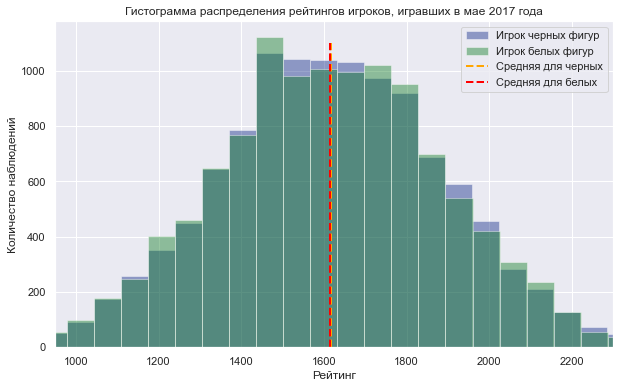

In [433]:
plt.figure(figsize=(10, 6))
plt.hist(info['black_elo'], bins = 30, alpha = 0.4, rwidth = 2, label= 'Игрок черных фигур')
plt.hist(info['white_elo'], bins = 30,alpha = 0.4, rwidth = 2, label= 'Игрок белых фигур')
plt.vlines(info['black_elo'].mean(), 0, 1100, color='orange', lw=2, linestyles='--', label='Средняя для черных')
plt.vlines(info['white_elo'].mean(), 0, 1100, color='red', lw=2, linestyles='--', label='Средняя для белых')
plt.show
plt.title(f'Гистограмма распределения рейтингов игроков, игравших в мае 2017 года')
plt.xlabel("Рейтинг")
plt.ylabel("Количество наблюдений")
plt.xlim((950, 2300))
plt.legend()
None

**Вывод**: Визуально выбороные средние рейтингов игроков у белых и черных равны. Однако это не демонстрирует статистическую значимость данного высказывания. Более того, данное распределение очень похоже на нормальное, можем даже проверить:

In [434]:
#По-быстрому простандартизируем:
x = info['black_elo']
y = info['white_elo']
x_mean = x.mean()
y_mean = y.mean()
x_std = x.std()
y_std = y.std()

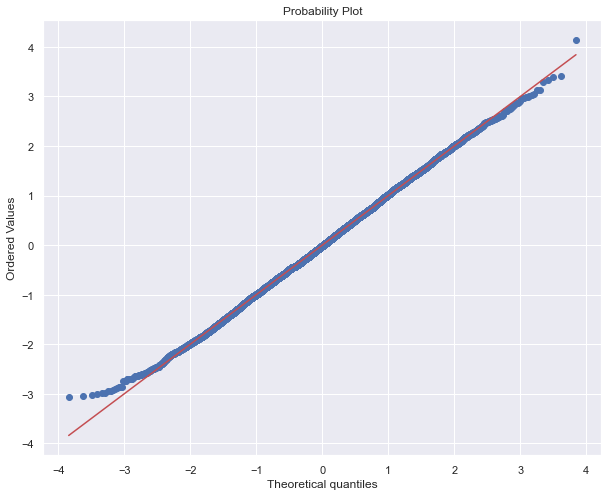

In [435]:
sns.set(rc={'figure.figsize':(10,8)})
x_scale = (x - x_mean)/x_std
sts.probplot(x_scale, dist="norm", plot=plt);

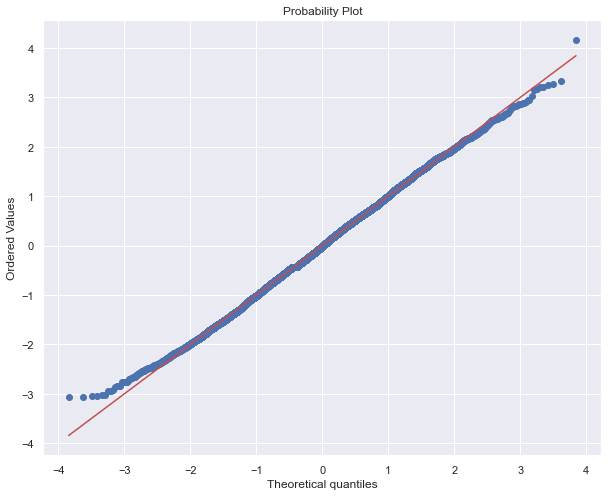

In [436]:
y_scale = (y - y_mean)/y_std
sts.probplot(y_scale, dist="norm", plot=plt);

**Вывод:** Обе выборки практически идеально стремятся к стандартному нормальному распределению, однако на концах все же есть некоторые выборсы у обоих цветов

### 2. Построим столбчатую диаграмму типов игр в заивимости от временного режима

In [437]:
info['time_control'] = info['time_control'].astype("category")
info['time_control'].value_counts()[:10]

600+0     4387
900+15     903
900+0      719
300+5      478
480+0      413
300+8      339
600+5      313
1200+0     312
900+10     264
600+10     245
Name: time_control, dtype: int64

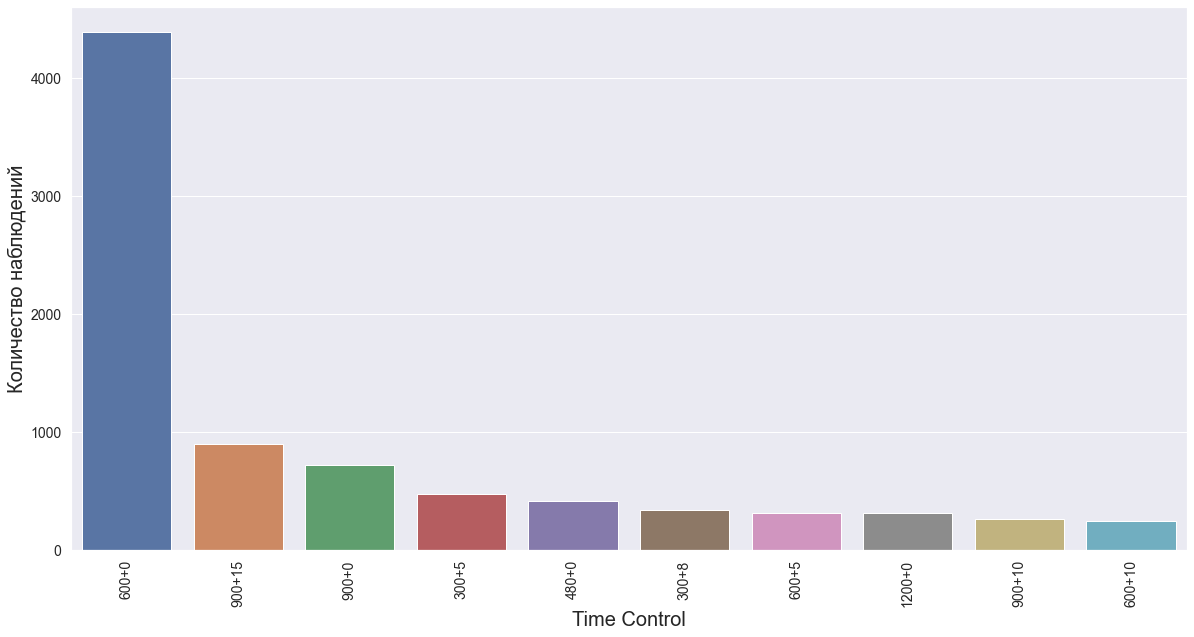

In [438]:
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x = info['time_control'].value_counts().index.tolist()[:10], y = info['time_control'].value_counts().values.tolist()[:10])
plt.xticks(rotation=90)
plt.xlabel('Time Control', fontsize=20)
plt.ylabel('Количество наблюдений', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
None

**Вывод:** Наиболее популярным, как и ожидалось, является 10-минутный режим без добавления дополнительного времени при совершении хода (+0). Далее по популярности идут 15-минутные, 6-минутные и 8-минутные игры, но их значительно меньше

### 2. Построим столбчатую диаграмму выйгранных партий белыми и черными

In [439]:
info['result_coded'] = np.where(info['result'] == '1-0', 'w', 'b')
info['result_coded'].value_counts()

b    5823
w    5608
Name: result_coded, dtype: int64

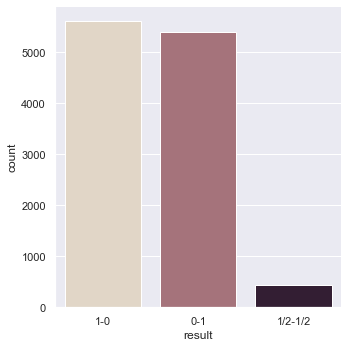

In [440]:
ax = sns.catplot(data = info, x = 'result' , kind="count", palette="ch:.25")
None

**Вывод**: Ситуация как и в случае со средним рейтингом: значения у черных и у белых визуально примерно одинаковы, однако статистически значимой ли является данная гипотеза или нет, предстоит  проверить

### 3. Построим столбчатую диаграмму распределения дебютов

In [441]:
#Всего в датасете представлено 573 уникальных дебюта, 260 из которых используются 10 и более раз
info['op'].value_counts()[:260]

Sicilian Defense: Bowdler Attack                 190
Sicilian Defense                                 159
Scandinavian Defense: Mieses-Kotroc Variation    154
Van't Kruijs Opening                             153
Queen's Pawn Game: Chigorin Variation            149
                                                ... 
Reti Opening #2                                   10
Alekhine Defense: Two Pawn Attack                 10
Sicilian Defense: Sozin, not Scheveningen         10
Queen's Gambit                                    10
Richter-Veresov Attack                            10
Name: op, Length: 260, dtype: int64

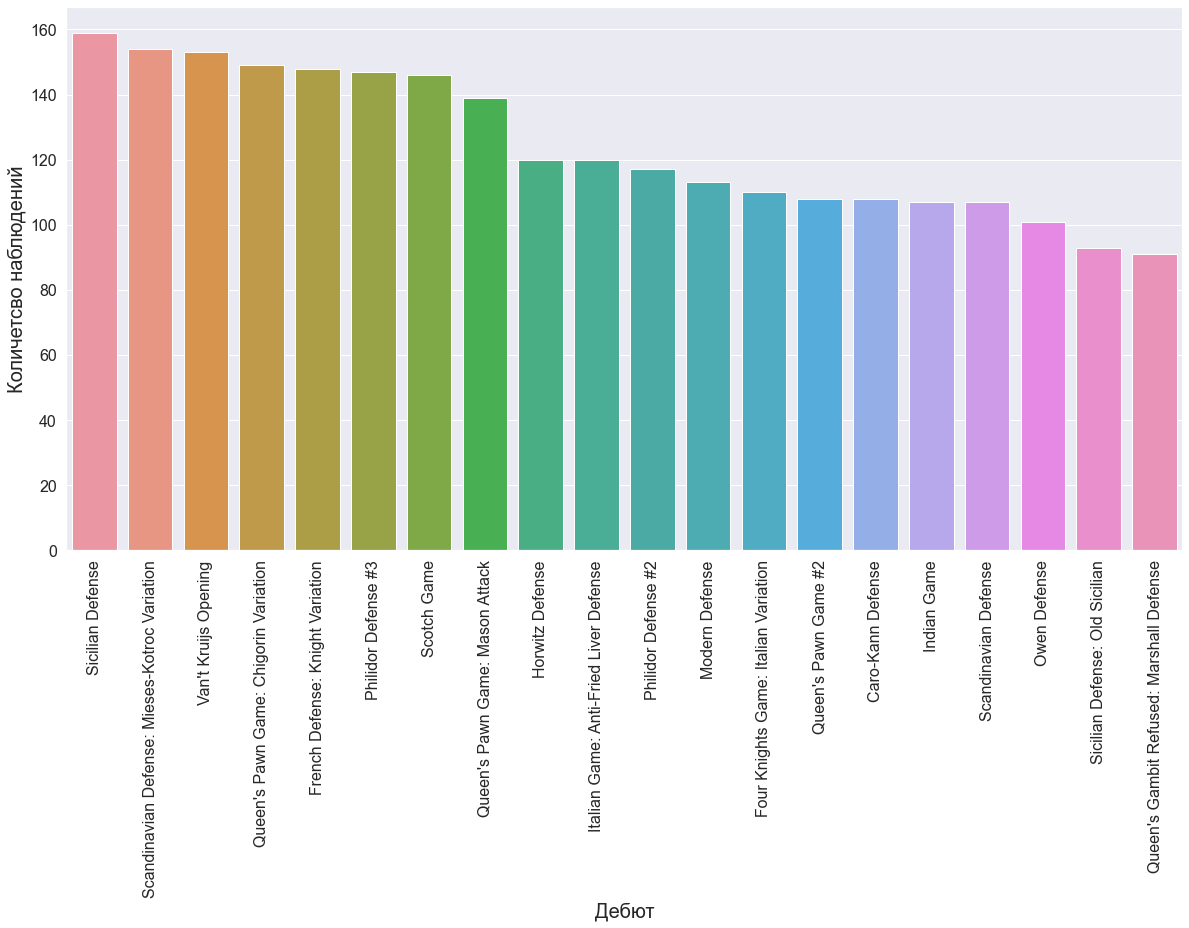

In [442]:
#Для качетсвенной визуализации выберем только те, которые используются более 90 раз (всего 21 вид)
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x = info['op'].value_counts()[1:21].index, y = info['op'].value_counts()[1:21].values)
plt.xticks(rotation=90)
plt.xlabel('Дебют', fontsize=20)
plt.ylabel('Количетсво наблюдений', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
None

**Вывод:** Как и ожидалось, наиболее популярными дебютами являются Сицилийская, Скандинавская защита, а также всевозможные вариации дебюта королевских пешек. Также стоит отметить, что среди игроков нет какой-то одной тактики, которую ипользуют все - распределение относительно равномерно

### 4. Построим столбчатую диаграмму распределения фигур, которыми чаще всего ходят игроки (можно сделать в зависимости от рейтинга)

In [443]:
moves['piece_cat'] = moves['piece'].astype("category")

P    204473
N    132494
B    116275
R     99304
Q     98322
K     91486
Name: piece_cat, dtype: int64


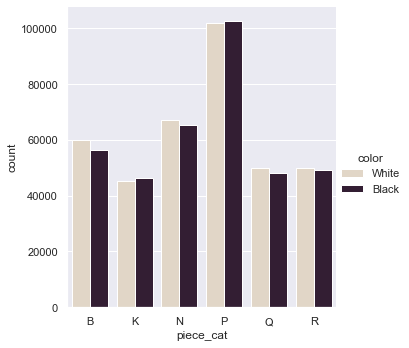

In [444]:
print(moves['piece_cat'].value_counts())
ax = sns.catplot(data = moves, x = 'piece_cat' , kind="count", palette="ch:.25", hue = 'color')
None

**Расшифруем:**
* B(Bishop) - Слон
* K(King) - Король
* N(Night) - Лошадь
* P(Pawn) - Пешка
* Q(Queen) - Ферзь
* R(Rook) - Ладья

**Вывод:** Наиболее популярными фигурами являются Лошадь и Пешка (вызвано это в том числе и тем, что они практически всегда первыми участвуют в дебюте, в то время как остальные фигуры могут быть разыграны только к середине игры.

### 5. Динамика оценки ходов в зависимости от уровня игроков
(Для большей наглядности возьмем игры с одинаковым time_control)

##### Идея - визуально сравнить графики оценок для разных категорий игроков в соответствии с рейтингом

In [445]:
# Возьмем крутых игроков
game = info[(info['time_control'] == '600+0') & (info['white_elo'] > 2000) & (info['black_elo'] > 2000)].iloc[1,:]['game_id']
evalu = moves[moves['game_id'] == game]['eval']
hod = range(moves[moves['game_id'] == game].shape[0])

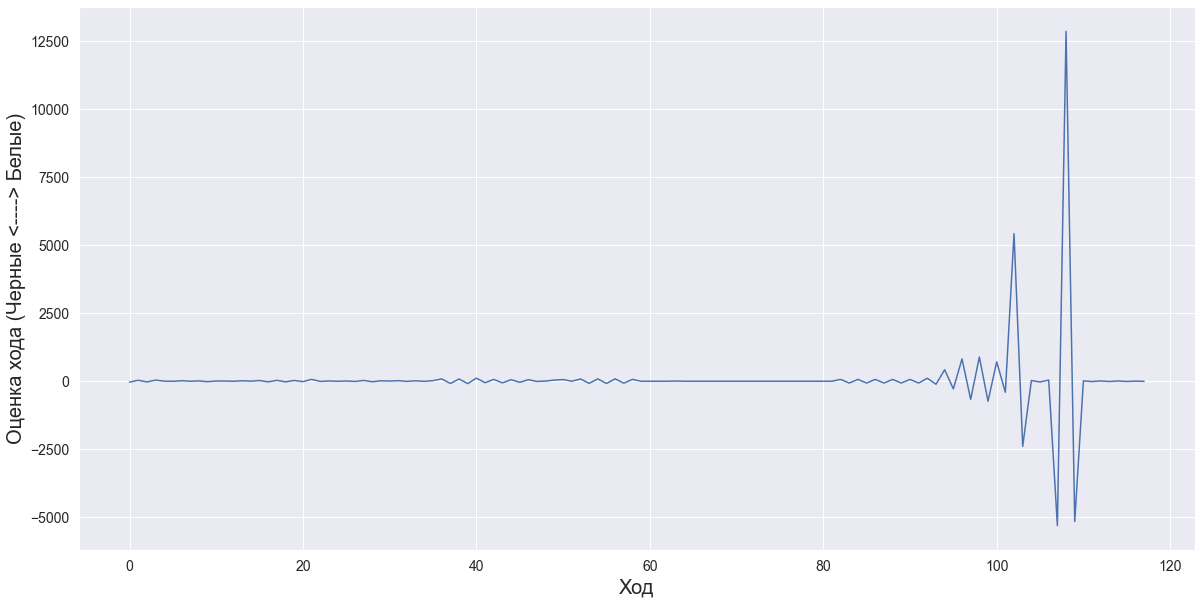

In [446]:
data_plot = pd.DataFrame({"Hod":hod, "Eval":evalu})
sns.lineplot(x = "Hod", y = "Eval", data=data_plot)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Ход', fontsize=20)
plt.ylabel('Оценка хода (Черные <----> Белые)', fontsize=20)
None

**Вывод:** Идеально ровная игра без единой ошибки на протяжении почти 100 ходов - одна из выраженных характеристик игр профессионалов

In [447]:
# Возьмем более слабых игроков
game = info[(info['time_control'] == '600+0') & (info['white_elo'] < 1300) & (info['black_elo'] < 1300)].iloc[1,:]['game_id']
evalu = moves[moves['game_id'] == game]['eval']
hod = range(moves[moves['game_id'] == game].shape[0])

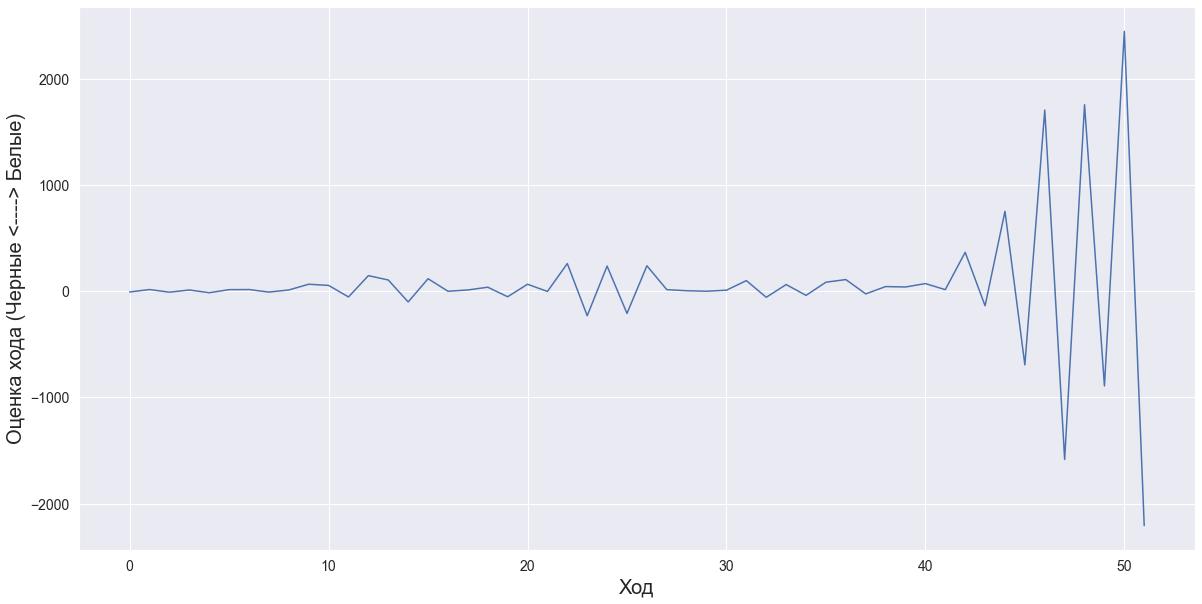

In [448]:
data_plot = pd.DataFrame({"Hod":hod, "Eval":evalu})
sns.lineplot(x = "Hod", y = "Eval", data=data_plot)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Ход', fontsize=20)
plt.ylabel('Оценка хода (Черные <----> Белые)', fontsize=20)
None

**Вывод:** На протяжении всей игры оценки колеблелись - игроки ошибаются и дают друг другу преимущество. Также отметим, что игра закончилась достаточно быстро, что означает относительную неравность в способностях игроков на низких уровнях в связи с зачастую хаотичной и неструктурированной игрой

# 2) Создание новых признаков

### Сначала работаем с датафреймом, содержащим основную информацию

1. **Выделим средний рейтинг игроков в одной партии - это поможет более качественно классифицировать их и загнать в категориальные признаки**

In [449]:
x = ((info['white_elo'] + info['black_elo'])/2).to_frame()
info['avg_rate'] = x

Оказалось, что классификация,представленная в репозитории, слишком точно определяет категории, именно поэтому придется применить собственную классификацию:
1. Меньше 1350 - новички
2. 1350 - 1700 - средние игроки
3. 1700 - 1900 - высокоуровневые игроки
4. Выше 1900 - крайне сильные игроки

In [450]:
arara = np.digitize(info['avg_rate'],[info['avg_rate'].min(),1350.,1700.,1900., info['avg_rate'].max()])
info['skill_cat'] = arara

In [451]:
info.head()

,game_id,result,white_elo,black_elo,winner_loser_elo_diff,eco,termination,time_control,op,result_coded,avg_rate,skill_cat
0,c17b10c9-84c5-4c85-8c3b-b7866d0e25de,1-0,1607,1470,137,A04,Time forfeit,300+10,Zukertort Opening: Black Mustang Defense,w,1538.5,2
1,63fbeb77-cbcf-4e0a-ba24-a9fcce5c5c4f,1-0,1723,1702,21,C34,Time forfeit,600+0,"King's Gambit Accepted, Fischer Defense",w,1712.5,3
2,6c678d21-9c2c-47cc-acc8-e4d4be1aeb51,0-1,2030,1955,-75,B28,Normal,600+0,"Sicilian Defense: O'Kelly Variation, Normal Sy...",b,1992.5,4
3,77346e14-a662-424c-94f0-37330765c1d0,1-0,1462,1455,7,C61,Normal,600+0,Ruy Lopez: Bird Variation,w,1458.5,2
4,ad728a3a-85df-4727-a596-e0c5e56b5f8e,0-1,1375,1142,-233,C42,Normal,480+0,Russian Game: Three Knights Game,b,1258.5,1


2. **Переведем time_control в более удобный формат, взяв только изначальное значение секунд, доступное игроку для ходов в течение игры. Данный признак понадобится в дальшейшей работе с ходами**

In [452]:
x = info['time_control'].to_frame()
x[['A', 'B']] = x['time_control'].str.split('+', 1, expand=True)
info['seconds'] = x['A'].astype(int)

600     5464
900     2308
300     1004
480      576
1200     535
1800     365
1500     195
420      184
720      145
360      100
540       93
180       61
840       49
3600      46
2700      42
Name: seconds, dtype: int64


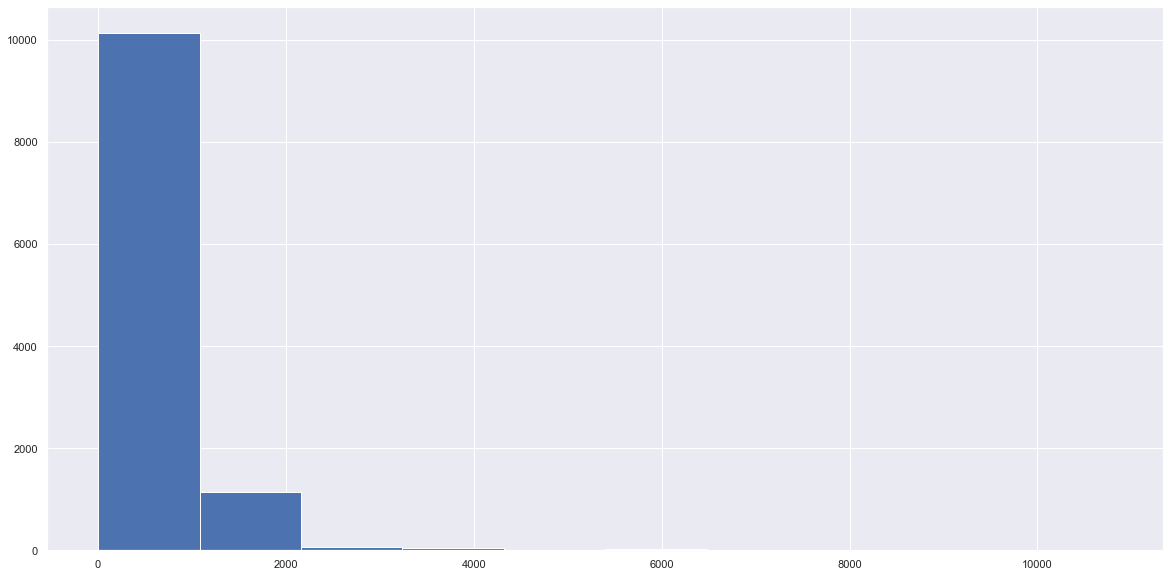

In [453]:
print(info['seconds'].value_counts()[:15])
plt.hist(info['seconds'])
None

In [454]:
info = info[info['seconds'].isin(info['seconds'].value_counts()[:15].index)]
moves = moves[moves['game_id'].isin(info['game_id'].values)]
info.shape, moves.shape

((11167, 13), (725071, 67))

Если вдруг качество модели будет плохим, можно будет загнать данные переменные в категориальные:

1. Длинная игра
2. Средняя
3. Короткая

3. **Выделим категории дебютов. Подробнее о них расписано в README**

C    4568
B    2871
A    1868
D    1642
E     218
Name: eco_cat, dtype: int64


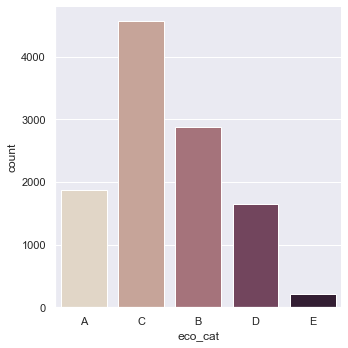

In [455]:
info['eco_cat'] = info['eco'].str[0]
print(info['eco_cat'].value_counts())
ax = sns.catplot(data = info, x = 'eco_cat' , kind="count", palette="ch:.25")
None

**Вывод:** Наиболее популярными являются наиболее простые открытые дебюты, а наименее - индийская защита

### Деперь начнем создавать признаки из датафрейма с ходами

1. Количество ходов за игру

In [456]:
hodi = moves.groupby('game_id').size().to_frame().reset_index() #количество ходов за игру

In [457]:
info = info.merge(hodi, how='left', on='game_id')
info.head()

,game_id,result,white_elo,black_elo,winner_loser_elo_diff,eco,termination,time_control,op,result_coded,avg_rate,skill_cat,seconds,eco_cat,0
0,c17b10c9-84c5-4c85-8c3b-b7866d0e25de,1-0,1607,1470,137,A04,Time forfeit,300+10,Zukertort Opening: Black Mustang Defense,w,1538.5,2,300,A,13
1,63fbeb77-cbcf-4e0a-ba24-a9fcce5c5c4f,1-0,1723,1702,21,C34,Time forfeit,600+0,"King's Gambit Accepted, Fischer Defense",w,1712.5,3,600,C,67
2,6c678d21-9c2c-47cc-acc8-e4d4be1aeb51,0-1,2030,1955,-75,B28,Normal,600+0,"Sicilian Defense: O'Kelly Variation, Normal Sy...",b,1992.5,4,600,B,34
3,77346e14-a662-424c-94f0-37330765c1d0,1-0,1462,1455,7,C61,Normal,600+0,Ruy Lopez: Bird Variation,w,1458.5,2,600,C,37
4,ad728a3a-85df-4727-a596-e0c5e56b5f8e,0-1,1375,1142,-233,C42,Normal,480+0,Russian Game: Three Knights Game,b,1258.5,1,480,C,30


**Далее разделим каждую игру на 3 части:**

In [ ]:
#Вариант кода для деления на 3 части
unique_values = moves['game_id'].unique()

for value in tqdm(unique_values):
    total_rows = len(moves[ moves['game_id'] == value])
    midpoint = total_rows // 2
    moves.loc[moves['game_id'] == value, 'IsFirstHalf'] = moves.loc[moves['game_id'] == value].index < midpoint

In [299]:
unique_values = moves['game_id'].unique()

for value in tqdm(unique_values):
    subset = moves[moves['game_id'] == value]
    total_rows = len(subset)
    
    indices = np.arange(total_rows)
    thirds = np.array_split(indices, 3)
    
    moves.loc[subset.index, 'Third'] = ""
    
    for i, indices_third in enumerate(thirds):
        moves.loc[subset.index[indices_third], 'Third'] = f'Third {i+1}'

100%|██████████| 11167/11167 [15:00<00:00, 12.40it/s]


In [300]:
moves['Third'].value_counts()

Third 1    245379
Third 2    241736
Third 3    237956
Name: Third, dtype: int64

In [301]:
#moves.to_csv('with_thirds.csv')

2. Посчитаем стандартное отклонение оценок в каждой трети игры

In [458]:
moves = pd.read_csv('with_thirds.csv')

In [459]:
grouped_evals = moves.groupby(['game_id', 'Third'])['eval'].std().to_frame().reset_index()
grouped_evals.head()

,game_id,Third,eval
0,000283ac-6b37-4f48-8e7d-4a8cf28fca93,Third 1,39.101989
1,000283ac-6b37-4f48-8e7d-4a8cf28fca93,Third 2,116.610684
2,000283ac-6b37-4f48-8e7d-4a8cf28fca93,Third 3,561.575699
3,000f2c5a-68e1-4d9d-a4e2-697ffe0d75f4,Third 1,57.534917
4,000f2c5a-68e1-4d9d-a4e2-697ffe0d75f4,Third 2,98.024713


In [462]:
fst_third = grouped_evals[grouped_evals['Third'] == 'Third 1']
info = info.merge(fst_third, how='left', on='game_id')

,game_id,result,white_elo,black_elo,winner_loser_elo_diff,eco,termination,time_control,op,result_coded,avg_rate,skill_cat,seconds,eco_cat,0,Third,eval
0,c17b10c9-84c5-4c85-8c3b-b7866d0e25de,1-0,1607,1470,137,A04,Time forfeit,300+10,Zukertort Opening: Black Mustang Defense,w,1538.5,2,300,A,13,Third 1,22.360680
1,63fbeb77-cbcf-4e0a-ba24-a9fcce5c5c4f,1-0,1723,1702,21,C34,Time forfeit,600+0,"King's Gambit Accepted, Fischer Defense",w,1712.5,3,600,C,67,Third 1,207.761854
2,6c678d21-9c2c-47cc-acc8-e4d4be1aeb51,0-1,2030,1955,-75,B28,Normal,600+0,"Sicilian Defense: O'Kelly Variation, Normal Sy...",b,1992.5,4,600,B,34,Third 1,20.529912
3,77346e14-a662-424c-94f0-37330765c1d0,1-0,1462,1455,7,C61,Normal,600+0,Ruy Lopez: Bird Variation,w,1458.5,2,600,C,37,Third 1,45.041434
4,ad728a3a-85df-4727-a596-e0c5e56b5f8e,0-1,1375,1142,-233,C42,Normal,480+0,Russian Game: Three Knights Game,b,1258.5,1,480,C,30,Third 1,222.130717


In [463]:
info = info.rename(columns={'eval': 'eval_std1'})
info = info.drop(columns = 'Third')
info.head()

,game_id,result,white_elo,black_elo,winner_loser_elo_diff,eco,termination,time_control,op,result_coded,avg_rate,skill_cat,seconds,eco_cat,0,eval_std1
0,c17b10c9-84c5-4c85-8c3b-b7866d0e25de,1-0,1607,1470,137,A04,Time forfeit,300+10,Zukertort Opening: Black Mustang Defense,w,1538.5,2,300,A,13,22.360680
1,63fbeb77-cbcf-4e0a-ba24-a9fcce5c5c4f,1-0,1723,1702,21,C34,Time forfeit,600+0,"King's Gambit Accepted, Fischer Defense",w,1712.5,3,600,C,67,207.761854
2,6c678d21-9c2c-47cc-acc8-e4d4be1aeb51,0-1,2030,1955,-75,B28,Normal,600+0,"Sicilian Defense: O'Kelly Variation, Normal Sy...",b,1992.5,4,600,B,34,20.529912
3,77346e14-a662-424c-94f0-37330765c1d0,1-0,1462,1455,7,C61,Normal,600+0,Ruy Lopez: Bird Variation,w,1458.5,2,600,C,37,45.041434
4,ad728a3a-85df-4727-a596-e0c5e56b5f8e,0-1,1375,1142,-233,C42,Normal,480+0,Russian Game: Three Knights Game,b,1258.5,1,480,C,30,222.130717


In [464]:
snd_third = grouped_evals[grouped_evals['Third'] == 'Third 2']
info = info.merge(snd_third, how='left', on='game_id')
info.head()

,game_id,result,white_elo,black_elo,winner_loser_elo_diff,eco,termination,time_control,op,result_coded,avg_rate,skill_cat,seconds,eco_cat,0,eval_std1,Third,eval
0,c17b10c9-84c5-4c85-8c3b-b7866d0e25de,1-0,1607,1470,137,A04,Time forfeit,300+10,Zukertort Opening: Black Mustang Defense,w,1538.5,2,300,A,13,22.360680,Third 2,34.355980
1,63fbeb77-cbcf-4e0a-ba24-a9fcce5c5c4f,1-0,1723,1702,21,C34,Time forfeit,600+0,"King's Gambit Accepted, Fischer Defense",w,1712.5,3,600,C,67,207.761854,Third 2,468.703935
2,6c678d21-9c2c-47cc-acc8-e4d4be1aeb51,0-1,2030,1955,-75,B28,Normal,600+0,"Sicilian Defense: O'Kelly Variation, Normal Sy...",b,1992.5,4,600,B,34,20.529912,Third 2,391.709911
3,77346e14-a662-424c-94f0-37330765c1d0,1-0,1462,1455,7,C61,Normal,600+0,Ruy Lopez: Bird Variation,w,1458.5,2,600,C,37,45.041434,Third 2,24.756389
4,ad728a3a-85df-4727-a596-e0c5e56b5f8e,0-1,1375,1142,-233,C42,Normal,480+0,Russian Game: Three Knights Game,b,1258.5,1,480,C,30,222.130717,Third 2,276.295816


In [465]:
info = info.rename(columns={'eval': 'eval_std2'})
info = info.drop(columns = 'Third')
info.head()

,game_id,result,white_elo,black_elo,winner_loser_elo_diff,eco,termination,time_control,op,result_coded,avg_rate,skill_cat,seconds,eco_cat,0,eval_std1,eval_std2
0,c17b10c9-84c5-4c85-8c3b-b7866d0e25de,1-0,1607,1470,137,A04,Time forfeit,300+10,Zukertort Opening: Black Mustang Defense,w,1538.5,2,300,A,13,22.360680,34.355980
1,63fbeb77-cbcf-4e0a-ba24-a9fcce5c5c4f,1-0,1723,1702,21,C34,Time forfeit,600+0,"King's Gambit Accepted, Fischer Defense",w,1712.5,3,600,C,67,207.761854,468.703935
2,6c678d21-9c2c-47cc-acc8-e4d4be1aeb51,0-1,2030,1955,-75,B28,Normal,600+0,"Sicilian Defense: O'Kelly Variation, Normal Sy...",b,1992.5,4,600,B,34,20.529912,391.709911
3,77346e14-a662-424c-94f0-37330765c1d0,1-0,1462,1455,7,C61,Normal,600+0,Ruy Lopez: Bird Variation,w,1458.5,2,600,C,37,45.041434,24.756389
4,ad728a3a-85df-4727-a596-e0c5e56b5f8e,0-1,1375,1142,-233,C42,Normal,480+0,Russian Game: Three Knights Game,b,1258.5,1,480,C,30,222.130717,276.295816


In [466]:
lst_third = grouped_evals[grouped_evals['Third'] == 'Third 3']
info = info.merge(lst_third, how='left', on='game_id')
info.head()

,game_id,result,white_elo,black_elo,winner_loser_elo_diff,eco,termination,time_control,op,result_coded,avg_rate,skill_cat,seconds,eco_cat,0,eval_std1,eval_std2,Third,eval
0,c17b10c9-84c5-4c85-8c3b-b7866d0e25de,1-0,1607,1470,137,A04,Time forfeit,300+10,Zukertort Opening: Black Mustang Defense,w,1538.5,2,300,A,13,22.360680,34.355980,Third 3,43.091956
1,63fbeb77-cbcf-4e0a-ba24-a9fcce5c5c4f,1-0,1723,1702,21,C34,Time forfeit,600+0,"King's Gambit Accepted, Fischer Defense",w,1712.5,3,600,C,67,207.761854,468.703935,Third 3,345.992368
2,6c678d21-9c2c-47cc-acc8-e4d4be1aeb51,0-1,2030,1955,-75,B28,Normal,600+0,"Sicilian Defense: O'Kelly Variation, Normal Sy...",b,1992.5,4,600,B,34,20.529912,391.709911,Third 3,807.592348
3,77346e14-a662-424c-94f0-37330765c1d0,1-0,1462,1455,7,C61,Normal,600+0,Ruy Lopez: Bird Variation,w,1458.5,2,600,C,37,45.041434,24.756389,Third 3,765.173356
4,ad728a3a-85df-4727-a596-e0c5e56b5f8e,0-1,1375,1142,-233,C42,Normal,480+0,Russian Game: Three Knights Game,b,1258.5,1,480,C,30,222.130717,276.295816,Third 3,1057.605030


In [467]:
info = info.rename(columns={'eval': 'eval_std3'})
info = info.drop(columns = 'Third')
info.head()

,game_id,result,white_elo,black_elo,winner_loser_elo_diff,eco,termination,time_control,op,result_coded,avg_rate,skill_cat,seconds,eco_cat,0,eval_std1,eval_std2,eval_std3
0,c17b10c9-84c5-4c85-8c3b-b7866d0e25de,1-0,1607,1470,137,A04,Time forfeit,300+10,Zukertort Opening: Black Mustang Defense,w,1538.5,2,300,A,13,22.360680,34.355980,43.091956
1,63fbeb77-cbcf-4e0a-ba24-a9fcce5c5c4f,1-0,1723,1702,21,C34,Time forfeit,600+0,"King's Gambit Accepted, Fischer Defense",w,1712.5,3,600,C,67,207.761854,468.703935,345.992368
2,6c678d21-9c2c-47cc-acc8-e4d4be1aeb51,0-1,2030,1955,-75,B28,Normal,600+0,"Sicilian Defense: O'Kelly Variation, Normal Sy...",b,1992.5,4,600,B,34,20.529912,391.709911,807.592348
3,77346e14-a662-424c-94f0-37330765c1d0,1-0,1462,1455,7,C61,Normal,600+0,Ruy Lopez: Bird Variation,w,1458.5,2,600,C,37,45.041434,24.756389,765.173356
4,ad728a3a-85df-4727-a596-e0c5e56b5f8e,0-1,1375,1142,-233,C42,Normal,480+0,Russian Game: Three Knights Game,b,1258.5,1,480,C,30,222.130717,276.295816,1057.605030


**Сейчас занесем все признаки, а потом почистим таблицу**

2. Динамика потери фигур каждой стороной в каждой части игры

In [397]:
grouped_losses = moves.groupby(['game_id', 'Third'])['captured_score_for_white'].mean().to_frame().reset_index()
grouped_losses.head()

,game_id,Third,captured_score_for_white
0,000283ac-6b37-4f48-8e7d-4a8cf28fca93,Third 1,3.275862
1,000283ac-6b37-4f48-8e7d-4a8cf28fca93,Third 2,11.620690
2,000283ac-6b37-4f48-8e7d-4a8cf28fca93,Third 3,21.827586
3,000f2c5a-68e1-4d9d-a4e2-697ffe0d75f4,Third 1,0.000000
4,000f2c5a-68e1-4d9d-a4e2-697ffe0d75f4,Third 2,0.800000


In [468]:
fst_third = grouped_losses[grouped_losses['Third'] == 'Third 1']
info = info.merge(fst_third, how='left', on='game_id')

info.head()

,game_id,result,white_elo,black_elo,winner_loser_elo_diff,eco,termination,time_control,op,result_coded,avg_rate,skill_cat,seconds,eco_cat,0,eval_std1,eval_std2,eval_std3,Third,captured_score_for_white
0,c17b10c9-84c5-4c85-8c3b-b7866d0e25de,1-0,1607,1470,137,A04,Time forfeit,300+10,Zukertort Opening: Black Mustang Defense,w,1538.5,2,300,A,13,22.360680,34.355980,43.091956,Third 1,0.000000
1,63fbeb77-cbcf-4e0a-ba24-a9fcce5c5c4f,1-0,1723,1702,21,C34,Time forfeit,600+0,"King's Gambit Accepted, Fischer Defense",w,1712.5,3,600,C,67,207.761854,468.703935,345.992368,Third 1,1.043478
2,6c678d21-9c2c-47cc-acc8-e4d4be1aeb51,0-1,2030,1955,-75,B28,Normal,600+0,"Sicilian Defense: O'Kelly Variation, Normal Sy...",b,1992.5,4,600,B,34,20.529912,391.709911,807.592348,Third 1,0.500000
3,77346e14-a662-424c-94f0-37330765c1d0,1-0,1462,1455,7,C61,Normal,600+0,Ruy Lopez: Bird Variation,w,1458.5,2,600,C,37,45.041434,24.756389,765.173356,Third 1,1.153846
4,ad728a3a-85df-4727-a596-e0c5e56b5f8e,0-1,1375,1142,-233,C42,Normal,480+0,Russian Game: Three Knights Game,b,1258.5,1,480,C,30,222.130717,276.295816,1057.605030,Third 1,0.200000


In [469]:
info = info.rename(columns={'captured_score_for_white': 'loss1'})
info = info.drop(columns = 'Third')

snd_third = grouped_losses[grouped_losses['Third'] == 'Third 2']
info = info.merge(snd_third, how='left', on='game_id')

info = info.rename(columns={'captured_score_for_white': 'loss2'})
info = info.drop(columns = 'Third')

trd_third = grouped_losses[grouped_losses['Third'] == 'Third 3']
info = info.merge(trd_third, how='left', on='game_id')

info = info.rename(columns={'captured_score_for_white': 'loss3'})
info = info.drop(columns = 'Third')

info.head()

,game_id,result,white_elo,black_elo,winner_loser_elo_diff,eco,termination,time_control,op,result_coded,...,skill_cat,seconds,eco_cat,0,eval_std1,eval_std2,eval_std3,loss1,loss2,loss3
0,c17b10c9-84c5-4c85-8c3b-b7866d0e25de,1-0,1607,1470,137,A04,Time forfeit,300+10,Zukertort Opening: Black Mustang Defense,w,...,2,300,A,13,22.360680,34.355980,43.091956,0.000000,0.000000,0.750000
1,63fbeb77-cbcf-4e0a-ba24-a9fcce5c5c4f,1-0,1723,1702,21,C34,Time forfeit,600+0,"King's Gambit Accepted, Fischer Defense",w,...,3,600,C,67,207.761854,468.703935,345.992368,1.043478,2.409091,7.727273
2,6c678d21-9c2c-47cc-acc8-e4d4be1aeb51,0-1,2030,1955,-75,B28,Normal,600+0,"Sicilian Defense: O'Kelly Variation, Normal Sy...",b,...,4,600,B,34,20.529912,391.709911,807.592348,0.500000,3.272727,12.181818
3,77346e14-a662-424c-94f0-37330765c1d0,1-0,1462,1455,7,C61,Normal,600+0,Ruy Lopez: Bird Variation,w,...,2,600,C,37,45.041434,24.756389,765.173356,1.153846,3.750000,8.416667
4,ad728a3a-85df-4727-a596-e0c5e56b5f8e,0-1,1375,1142,-233,C42,Normal,480+0,Russian Game: Three Knights Game,b,...,1,480,C,30,222.130717,276.295816,1057.605030,0.200000,3.000000,6.000000


3. **Посчитаем средний eval за игру** - это показывает, кто из игроков доминировал во время игры

In [470]:
meana = moves.groupby('game_id')['eval'].mean().to_frame().reset_index()
meana.head()

,game_id,eval
0,000283ac-6b37-4f48-8e7d-4a8cf28fca93,-4.712644
1,000f2c5a-68e1-4d9d-a4e2-697ffe0d75f4,32.655172
2,000f4167-632a-4c2c-b697-6d73a300b3b2,28.640000
3,001e6113-fc66-4bdc-b449-2eec17d81035,56.655172
4,0022bce0-e3bc-4cd1-b7c2-b49728d4de27,11.416667


In [471]:
info = info.merge(meana, how='left', on='game_id')
info.head()

,game_id,result,white_elo,black_elo,winner_loser_elo_diff,eco,termination,time_control,op,result_coded,...,seconds,eco_cat,0,eval_std1,eval_std2,eval_std3,loss1,loss2,loss3,eval
0,c17b10c9-84c5-4c85-8c3b-b7866d0e25de,1-0,1607,1470,137,A04,Time forfeit,300+10,Zukertort Opening: Black Mustang Defense,w,...,300,A,13,22.360680,34.355980,43.091956,0.000000,0.000000,0.750000,15.538462
1,63fbeb77-cbcf-4e0a-ba24-a9fcce5c5c4f,1-0,1723,1702,21,C34,Time forfeit,600+0,"King's Gambit Accepted, Fischer Defense",w,...,600,C,67,207.761854,468.703935,345.992368,1.043478,2.409091,7.727273,73.910448
2,6c678d21-9c2c-47cc-acc8-e4d4be1aeb51,0-1,2030,1955,-75,B28,Normal,600+0,"Sicilian Defense: O'Kelly Variation, Normal Sy...",b,...,600,B,34,20.529912,391.709911,807.592348,0.500000,3.272727,12.181818,27.735294
3,77346e14-a662-424c-94f0-37330765c1d0,1-0,1462,1455,7,C61,Normal,600+0,Ruy Lopez: Bird Variation,w,...,600,C,37,45.041434,24.756389,765.173356,1.153846,3.750000,8.416667,21.702703
4,ad728a3a-85df-4727-a596-e0c5e56b5f8e,0-1,1375,1142,-233,C42,Normal,480+0,Russian Game: Three Knights Game,b,...,480,C,30,222.130717,276.295816,1057.605030,0.200000,3.000000,6.000000,39.233333


In [472]:
info = info.rename(columns={'eval': 'mean_eval'})

4. **Разделим ходы каждой игры на 3 части и рассчитаем для каждой части стандартное откронение времи, оставшееся после хода**. В плане интервпретации данной величины могут возникнуть неточности, оданко данный показатель конркетно будет демонстрировать, насколько больше/меньше игроки думают в зависимости от части игры, то есть приближения к временному ограничению

In [474]:
moves['vremya'] = pd.to_datetime(moves['clk'], format='%H:%M:%S')

moves['vremya'] = moves['vremya'].dt.strftime('%H:%M:%S')
moves['vremya'] = pd.to_timedelta(moves['vremya']).dt.total_seconds()

In [475]:
clock = moves.groupby(['game_id', 'Third'])['vremya'].std().to_frame().reset_index()
clock.head()

,game_id,Third,vremya
0,000283ac-6b37-4f48-8e7d-4a8cf28fca93,Third 1,191.638592
1,000283ac-6b37-4f48-8e7d-4a8cf28fca93,Third 2,446.802689
2,000283ac-6b37-4f48-8e7d-4a8cf28fca93,Third 3,422.249474
3,000f2c5a-68e1-4d9d-a4e2-697ffe0d75f4,Third 1,5.432413
4,000f2c5a-68e1-4d9d-a4e2-697ffe0d75f4,Third 2,12.620970


In [476]:
fst_third = clock[clock['Third'] == 'Third 1']
info = info.merge(fst_third, how='left', on='game_id')

info = info.rename(columns={'vremya': 'vremya1'})
info = info.drop(columns = 'Third')

snd_third = clock[clock['Third'] == 'Third 2']
info = info.merge(snd_third, how='left', on='game_id')

info = info.rename(columns={'vremya': 'vremya2'})
info = info.drop(columns = 'Third')

trd_third = clock[clock['Third'] == 'Third 3']
info = info.merge(trd_third, how='left', on='game_id')

info = info.rename(columns={'vremya': 'vremya3'})
info = info.drop(columns = 'Third')

info.head()

,game_id,result,white_elo,black_elo,winner_loser_elo_diff,eco,termination,time_control,op,result_coded,...,eval_std1,eval_std2,eval_std3,loss1,loss2,loss3,mean_eval,vremya1,vremya2,vremya3
0,c17b10c9-84c5-4c85-8c3b-b7866d0e25de,1-0,1607,1470,137,A04,Time forfeit,300+10,Zukertort Opening: Black Mustang Defense,w,...,22.360680,34.355980,43.091956,0.000000,0.000000,0.750000,15.538462,4.929503,6.849574,16.580611
1,63fbeb77-cbcf-4e0a-ba24-a9fcce5c5c4f,1-0,1723,1702,21,C34,Time forfeit,600+0,"King's Gambit Accepted, Fischer Defense",w,...,207.761854,468.703935,345.992368,1.043478,2.409091,7.727273,73.910448,42.935285,67.584499,101.161790
2,6c678d21-9c2c-47cc-acc8-e4d4be1aeb51,0-1,2030,1955,-75,B28,Normal,600+0,"Sicilian Defense: O'Kelly Variation, Normal Sy...",b,...,20.529912,391.709911,807.592348,0.500000,3.272727,12.181818,27.735294,12.007573,30.279606,29.550881
3,77346e14-a662-424c-94f0-37330765c1d0,1-0,1462,1455,7,C61,Normal,600+0,Ruy Lopez: Bird Variation,w,...,45.041434,24.756389,765.173356,1.153846,3.750000,8.416667,21.702703,12.552454,17.417120,24.892953
4,ad728a3a-85df-4727-a596-e0c5e56b5f8e,0-1,1375,1142,-233,C42,Normal,480+0,Russian Game: Three Knights Game,b,...,222.130717,276.295816,1057.605030,0.200000,3.000000,6.000000,39.233333,8.030497,16.321765,59.676908


**ВСЕ! все необходимые данные собраны** Осталось причесать датафрейм:

In [477]:
info.columns

Index([              'game_id',                'result',
                   'white_elo',             'black_elo',
       'winner_loser_elo_diff',                   'eco',
                 'termination',          'time_control',
                          'op',          'result_coded',
                    'avg_rate',             'skill_cat',
                     'seconds',               'eco_cat',
                             0,             'eval_std1',
                   'eval_std2',             'eval_std3',
                       'loss1',                 'loss2',
                       'loss3',             'mean_eval',
                     'vremya1',               'vremya2',
                     'vremya3'],
      dtype='object')

In [478]:
upd_info = info[['game_id', 'termination', 'result_coded',
       'skill_cat', 'seconds', 'eco_cat', 0, 'eval_std1',
                   'eval_std2',             'eval_std3',
                       'loss1',                 'loss2',
                       'loss3',             'mean_eval',
                     'vremya1',               'vremya2',
                     'vremya3']]

In [479]:
upd_info.head()

,game_id,termination,result_coded,skill_cat,seconds,eco_cat,0,eval_std1,eval_std2,eval_std3,loss1,loss2,loss3,mean_eval,vremya1,vremya2,vremya3
0,c17b10c9-84c5-4c85-8c3b-b7866d0e25de,Time forfeit,w,2,300,A,13,22.360680,34.355980,43.091956,0.000000,0.000000,0.750000,15.538462,4.929503,6.849574,16.580611
1,63fbeb77-cbcf-4e0a-ba24-a9fcce5c5c4f,Time forfeit,w,3,600,C,67,207.761854,468.703935,345.992368,1.043478,2.409091,7.727273,73.910448,42.935285,67.584499,101.161790
2,6c678d21-9c2c-47cc-acc8-e4d4be1aeb51,Normal,b,4,600,B,34,20.529912,391.709911,807.592348,0.500000,3.272727,12.181818,27.735294,12.007573,30.279606,29.550881
3,77346e14-a662-424c-94f0-37330765c1d0,Normal,w,2,600,C,37,45.041434,24.756389,765.173356,1.153846,3.750000,8.416667,21.702703,12.552454,17.417120,24.892953
4,ad728a3a-85df-4727-a596-e0c5e56b5f8e,Normal,b,1,480,C,30,222.130717,276.295816,1057.605030,0.200000,3.000000,6.000000,39.233333,8.030497,16.321765,59.676908


In [482]:
upd_info.shape

(11167, 17)

In [480]:
#Запишем полученный датафрейм в отдельный файл, он понадобится в разделе с машинным обучением

#upd_info.to_csv('machine_part.csv')

# 3) Проверка гипотез

1. Проверим, равны ли матожиданя рейтингов игроков, или все же существуют некоторые различия на уровне значимости 0.05:

    $H_{0}$: $\mu_{white}$ = $\mu_{black}$
    
    $H_{1}$: $\mu_{white}$ $\neq$ $\mu_{black}$

In [26]:
print("Значение статистики:", ztest(info['black_elo'], info['white_elo'], value=0)[0])
print("P-value:", ztest(info['black_elo'], info['white_elo'], value=0)[1])

Значение статистики: 0.5066750959278169
P-value: 0.6123828073624764


**Вывод:** Действительно нельзя отвергнуть гипотезу о равенстве матожиданий, так как значение z-статистики не попало в критическую область

2. Проверим гипотезу о том, что корреляция между средним рейтингом в партии и средним отклонением %eval на первом этапе игры равна 0.7

....